# AI Agent on Step Functions

In this notebook we will AWS Step Functions to create a simple AI Agent for SQL queries.

We will:

* [Reuse the local SQL Database](#reuse-local-sql-database)
* [Adjust the system prompt](#adjusting-the-system-prompt)
* [Add dynamic code tool](#add-dynamic-code-tool-to-the-sql-tools)
* [Create secure sandbox exnvironment](#creating-a-secure-sandbox-to-the-code-execution)
* [Add the new dynmaic tool to the script](#add-the-new-tool-to-chat-script)

### Visual improvements

We will use [rich library](https://github.com/Textualize/rich), and `rich-theme-manager` to make the output more readable, and supress warning messages.

In [1]:
from rich.console import Console
from rich_theme_manager import Theme, ThemeManager
import pathlib

theme_dir = pathlib.Path("themes")
theme_manager = ThemeManager(theme_dir=theme_dir)
dark = theme_manager.get("dark")

# Create a console with the dark theme
console = Console(theme=dark)

In [2]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

## Deploying the AI Agent on Step Functions

The concept of DAG that we have built in the previous notebook, can be easily deployed on AWS Step Functions. 

In [3]:
from IPython.display import SVG, display
display(SVG('images/stepfunctions_graph.svg'))

In [4]:
user_prompt = """
How the ratio of players from Miami is changind over the years between 1970 and 1990?
"""

In [5]:
tools = [
    {
      "name": "get_db_schema",
      "description": "Describe the schema of the SQLite database, including table names, and column names and types.",
      "input_schema": {
        "type": "object",
        "properties": {}
      }
    },
    {
      "name": "execute_sql_query",
      "description": "Return the query results of the given SQL query to the SQLite database.",
      "input_schema": {
        "type": "object",
        "properties": {
          "sql_query": {
            "type": "string",
            "description": "The sql query to execute against the SQLite database"
          }
        },
        "required": [
          "sql_query"
        ]
      }
    },
    {
      "name": "execute_python",
      "description": "Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error.",
      "input_schema": {
        "type": "object",
        "properties": {
          "code": {
            "type": "string",
            "description": "The python code to execute in a single cell."
          }
        },
        "required": [
          "code"
        ]
      }
    }
  ]

In [6]:
step_functions_input_payload = {
  "model": "claude-3",
  "system": "You are an expert business analyst with deep knowledge of SQL and visualization code in Python. Your job is to help users understand and analyze their internal baseball data. You have access to a set of tools, but only use them when needed. You also have access to a tool that allows execution of python code. Use it to generate the visualizations in your analysis. - the python code runs in jupyter notebook. - every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`. - display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file. - you can run any python code you want, everything is running in a secure sandbox environment.",
  "messages": [
    {
      "role": "user",
      "content": user_prompt
    }
  ],
  "tools": tools
}

In [7]:
import boto3
import time
import json

session = boto3.Session()
region = session.region_name
account_id = session.client('sts').get_caller_identity().get('Account')

stepfunctions = boto3.client('stepfunctions')
# Define your state machine ARN
state_machine_arn = f'arn:aws:states:{region}:{account_id}:stateMachine:SQL-AI-Agent-Implementation'

# Define your input payload
payload = step_functions_input_payload

try:
    # Start the execution
    response = stepfunctions.start_execution(
        stateMachineArn=state_machine_arn,
        input=json.dumps(payload)
    )
    
    execution_arn = response['executionArn']
    print(f"Started execution: {execution_arn}")
    
    # Wait for the execution to complete
    while True:
        # Get execution status
        execution = stepfunctions.describe_execution(
            executionArn=execution_arn
        )
        
        status = execution['status']
        print(f"Current status: {status}")
        
        if status in ['SUCCEEDED', 'FAILED', 'TIMED_OUT', 'ABORTED']:
            break
            
        time.sleep(5)  # Wait for 5 seconds before checking again
    
    # Get the output
    if status == 'SUCCEEDED':
        execution_output = json.loads(execution['output'])
    else:
        print(f"\nExecution ended with status: {status}")
        if 'error' in execution:
            print("Error:", execution['error'])
        if 'cause' in execution:
            print("Cause:", execution['cause'])

except Exception as e:
    print(f"Error: {str(e)}")

Started execution: arn:aws:states:us-west-2:672915487120:execution:SQL-AI-Agent-Implementation:2bb8e8bb-7a90-42cd-a2cd-aa82a8e5defd
Current status: RUNNING
Current status: RUNNING
Current status: RUNNING
Current status: RUNNING
Current status: RUNNING
Current status: RUNNING
Current status: RUNNING
Current status: RUNNING
Current status: RUNNING
Current status: SUCCEEDED


In [8]:
from rich.text import Text
from rich.panel import Panel

response_text = Text(execution_output['answer'])
styled_panel = Panel(
    response_text,
    title=f"{user_prompt}",
    expand=False,
    border_style="bold green",
    padding=(1, 1)
)

console.print(styled_panel)

╭────────────  How the ratio of players from Miami is changind over the years between 1970 and 1990?  ────────────╮
│                                                                                                                 │
│ Let's analyze the findings:                                                                                     │
│                                                                                                                 │
│ 1. The absolute number of Miami-born players in MLB remained relatively stable from 1985 to 1990, with:         │
│    - 3 players in 1985                                                                                          │
│    - 4 players from 1986 to 1990                                                                                │
│                                                                                                                 │
│ 2. The ratio of Miami-born players to total players shows some fluctuation:                                     │
│    - Started at about 0.545% in 1985                                                                            │
│    - Peaked at about 0.641% in 1987                                                                             │
│    - Gradually declined to about 0.461% by 1990                                                                 │
│                                                                                                                 │
│ 3. The data shows that while the absolute number of Miami players remained relatively stable, their proportion  │
│ in MLB slightly decreased over this period, mainly due to the growing total number of players in the league     │
│ (from 550 in 1985 to 867 in 1990).                                                                              │
│                                                                                                                 │
│ Note: The data is limited to 1985-1990 as this is what's available in the database. To get a complete picture   │
│ of the trend from 1970 to 1990, we would need additional historical data.                                       │
│                                                                                                                 │
│ The visualization shows both the absolute numbers (red line) and the ratio (blue line) to provide a             │
│ comprehensive view of the trends. The decline in ratio despite stable absolute numbers suggests that MLB was    │
│ expanding during this period, adding more players from other regions at a faster rate than from Miami.          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


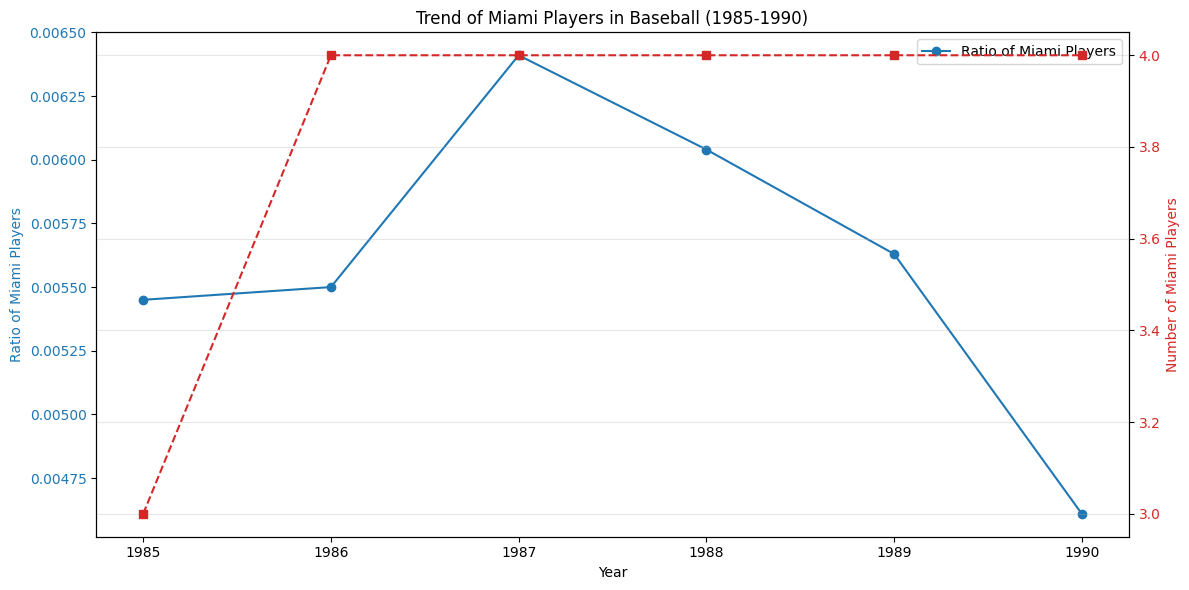

In [9]:
# Display the base64 image from the output['chart] in the notebook cell output
import base64
from IPython.display import HTML

def show_image_chart():
    return f'<img src="data:image/png;base64,{execution_output["chart"]}">'

HTML(show_image_chart())

In [10]:
# Show the assistant messages from the output['messages]
def show_assistant_messages(output):
    for message in output['messages']:
        if message['role'] == 'assistant':
            console.print(message['content'])

In [11]:
show_assistant_messages(execution_output)

[
    {
        'text': "I'll help you analyze the trend of players from Miami over the years from 1970 to 1990. First, let
me check the database schema to see how we can get this information.",
        'type': 'text'
    },
    {'id': 'toolu_01FXDJ9ByNcML2e61MfjieTi', 'input': {}, 'name': 'get_db_schema', 'type': 'tool_use'}
]

[
    {
        'text': "We'll need to join this with the salary table to get the active years of players. Let's write a 
query to get the number of players born in Miami and total players per year, then calculate the ratio.",
        'type': 'text'
    },
    {
        'id': 'toolu_01FdMu6v2FqCt7AiytTA4YXG',
        'input': {
            'sql_query': "WITH miami_players AS (\n  SELECT DISTINCT s.year,\n         COUNT(DISTINCT CASE WHEN 
p.birth_city = 'Miami' AND p.birth_state = 'FL' THEN p.player_id END) as miami_players,\n         COUNT(DISTINCT 
p.player_id) as total_players\n  FROM salary s\n  JOIN player p ON s.player_id = p.player_id\n  WHERE s.year 
BETWEEN 1970 AND 1990\n  GROUP BY s.year\n)\nSELECT year,\n       miami_players,\n       total_players,\n       
CAST(miami_players AS FLOAT) / total_players as miami_ratio\nFROM miami_players\nORDER BY year;"
        },
        'name': 'execute_sql_query',
        'type': 'tool_use'
    }
]

[
    {
        'text': 'I notice that we only have salary data starting from 1985. Let me visualize this data to show the 
trend more clearly.',
        'type': 'text'
    },
    {
        'id': 'toolu_019zHjXu3znSuPG5fsVAZWTa',
        'input': {
            'code': "import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Create 
DataFrame from the query results\ndata = {\n    'year': [1985, 1986, 1987, 1988, 1989, 1990],\n    'miami_ratio': 
[0.00545, 0.00550, 0.00641, 0.00604, 0.00563, 0.00461],\n    'miami_players': [3, 4, 4, 4, 4, 4]\n}\ndf = 
pd.DataFrame(data)\n\n# Create the figure and axis\nfig, ax1 = plt.subplots(figsize=(12, 6))\n\n# Plot ratio 
line\ncolor = 'tab:blue'\nax1.set_xlabel('Year')\nax1.set_ylabel('Ratio of Miami Players', 
color=color)\nax1.plot(df['year'], df['miami_ratio'], color=color, marker='o')\nax1.tick_params(axis='y', 
labelcolor=color)\n\n# Create second y-axis for absolute numbers\nax2 = ax1.twinx()\ncolor = 
'tab:red'\nax2.set_ylabel('Number of Miami Players', color=color)\nax2.plot(df['year'], df['miami_players'], 
color=color, marker='s', linestyle='--')\nax2.tick_params(axis='y', labelcolor=color)\n\nplt.title('Trend of Miami 
Players in Baseball (1985-1990)')\nplt.grid(True, alpha=0.3)\n\n# Add legend\nlines1, labels1 = 
ax1.get_legend_handles_labels()\nlines2, labels2 = ax2.get_legend_handles_labels()\nax1.legend(['Ratio of Miami 
Players', 'Number of Miami Players'], \n           loc='upper right')\n\nplt.tight_layout()\nplt.show()"
        },
        'name': 'execute_python',
        'type': 'tool_use'
    }
]

[
    {
        'text': "Let's analyze the findings:\n\n1. The absolute number of Miami-born players in MLB remained 
relatively stable from 1985 to 1990, with:\n   - 3 players in 1985\n   - 4 players from 1986 to 1990\n\n2. The 
ratio of Miami-born players to total players shows some fluctuation:\n   - Started at about 0.545% in 1985\n   - 
Peaked at about 0.641% in 1987\n   - Gradually declined to about 0.461% by 1990\n\n3. The data shows that while the
absolute number of Miami players remained relatively stable, their proportion in MLB slightly decreased over this 
period, mainly due to the growing total number of players in the league (from 550 in 1985 to 867 in 1990).\n\nNote:
The data is limited to 1985-1990 as this is what's available in the database. To get a complete picture of the 
trend from 1970 to 1990, we would need additional historical data.\n\nThe visualization shows both the absolute 
numbers (red line) and the ratio (blue line) to provide a comprehensive view of the trends. The decline in ratio 
despite stable absolute numbers suggests that MLB was expanding during this period, adding more players from other 
regions at a faster rate than from Miami.",
        'type': 'text'
    }
]